In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../')

In [2]:
from Modules.scraping import *
from Modules.support_functions import *
from Modules.Growth_curve_fitting import *
import numpy as np
import os 
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = cut_down(scrap_covid_data())

# START scraping
### Requesting url nr 1
### Requesting url nr 2
# END scraping


In [4]:
def find_timepoint_zero(df):
    df["Timepoint"] = -1

    point_zero = df.loc[df['Infected']>0, "Date"][0]
    df.loc[df['Date'] == point_zero, "Timepoint"] = 0

    previous = -1
    for i, row in df.iterrows():
        if i == point_zero or previous != -1:
            previous = previous + 1
            df.at[i,'Timepoint'] = previous
            
    return df

In [5]:
# Get German data
DE = country_filter(data, Country='Germany')
DE = find_timepoint_zero(DE)
DE = DE[DE.Timepoint != -1]

In [6]:
CH = country_filter(data, Country='China')
CH = find_timepoint_zero(CH)
CH = CH[CH.Timepoint != -1]

### Plot growth rate of Covid 19 in Germany

Text(0,0.5,'Infections')

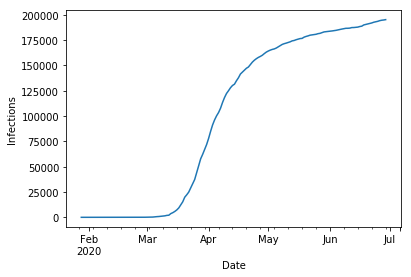

In [7]:
fig, ax = plt.subplots()
DE.loc[:,'Infected'].iloc[1:].plot()
ax.set_ylabel('Infections')

### Plot new infections of Covid 19 in Germany

Text(0,0.5,'New infections')

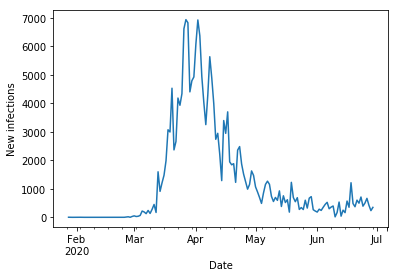

In [8]:
fig, ax = plt.subplots()
DE.loc[:,'Infected'].diff().iloc[1:].plot()
ax.set_ylabel('New infections')

### Plot log of growth rate of Covid 19 in Germany

Text(0,0.5,'New_Infections')

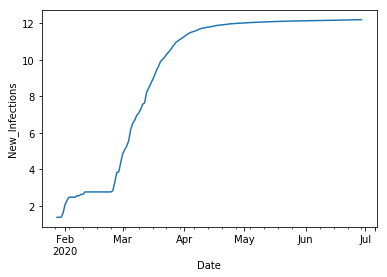

In [9]:
fig, ax = plt.subplots()
np.log(DE.loc[:,'Infected']).iloc[1:].plot()
ax.set_ylabel('New_Infections')


### Analyse the stationarity of the time series 

In [10]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print('AdFuller:',adfuller(np.log(DE.loc[:,'Infected']).diff()[1:])[1])
print('KPSS:',kpss(np.log(DE.loc[:,'Infected']).diff()[1:])[1])

AdFuller: 0.3116120528287291
KPSS: 0.02056121894509798


Indicates AR 1 Process


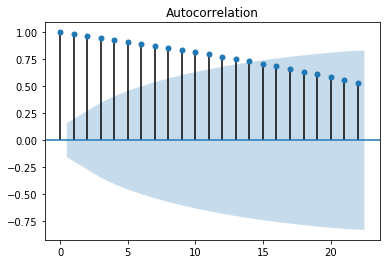

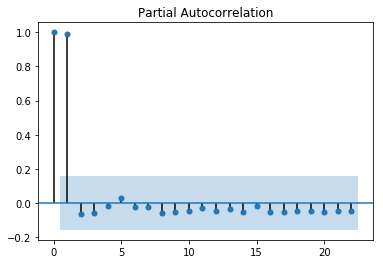

In [11]:
plot_acf(np.log(DE.loc[:,'Infected'])[1:])
plot_pacf(np.log(DE.loc[:,'Infected'])[1:])
print('Indicates AR 1 Process')

### Fit ARIMA model with Auto ARIMA 

In [12]:
from statsmodels.tools import eval_measures
from pyramid.arima import auto_arima
stepwise_model = auto_arima(np.log(DE.loc[:,'Infected'])[1:], start_p=0, start_q=0,
                           max_p=1, max_q=1, m=1,
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Fit ARIMA: order=(0, 1, 0); AIC=-194.676, BIC=-188.615, Fit time=0.567 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-280.101, BIC=-271.009, Fit time=0.955 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-250.015, BIC=-240.924, Fit time=0.125 seconds
Fit ARIMA: order=(1, 1, 1); AIC=-296.360, BIC=-284.238, Fit time=0.293 seconds
Total fit time: 2.052 seconds
-296.3602182557528


### Forecasting 

In [13]:
train = pd.Series(np.log(DE.loc[:,'Infected'])[1:-3])
test = pd.Series(np.log(DE.loc[:,'Infected'])[-3:])
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=3)
#Back transformation
train, test, future_forecast = np.exp(train), np.exp(test) , np.exp(future_forecast)
ARIMA_RMSE = eval_measures.rmse(test, future_forecast)
print('Root Mean Squared Error:',ARIMA_RMSE)

Root Mean Squared Error: 6203.67689670702


In [14]:
future_forecast = pd.Series(future_forecast, index= test.index)
test_series = train.append(test)
forecast_series = train.append(future_forecast)

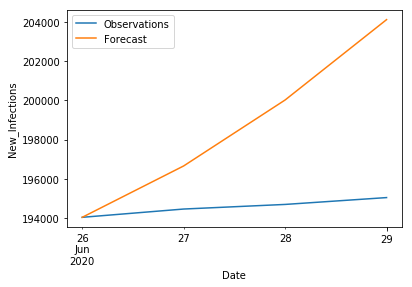

In [15]:
fig, ax = plt.subplots()
test_series.iloc[-4:].plot()
forecast_series.iloc[-4:].plot()
ax.set_ylabel('New_Infections')
ax.legend(['Observations', 'Forecast'])

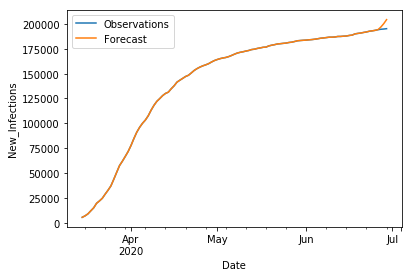

In [16]:
fig, ax = plt.subplots()
test_series.loc['2020-03-15':].plot()
forecast_series.loc['2020-03-15':].plot()
ax.set_ylabel('New_Infections')
ax.legend(['Observations', 'Forecast'])

## Fit dynamic linear model 

In [17]:
from pydlm import dlm, trend, dynamic, autoReg
dm = dlm(DE.loc[:,'Infected']) + trend(degree=2, discount=0.95, name='quad')
dm = dm + autoReg(degree=1, discount=0.95, name='AR1', w=1e7)
dm.fitForwardFilter()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.


## Forecasting with KalmanFilter 

In [18]:
KLpredict,pred_var = dm.predictN(N=3,date=dm.n - 3 )
next_day,_ = dm.predict()
print('Next day prediction:', next_day)

Next day prediction: [[195741.18147489]]


In [19]:
#Calculate the standard deviation
MSE = dm.getMSE()
print('Kalman RMSE:',np.sqrt(MSE))
print('ARIMA RMSE:',ARIMA_RMSE)

Kalman RMSE: 682.300340666081
ARIMA RMSE: 6203.67689670702


In [20]:
KLpredict = pd.Series(KLpredict, index= test.index)
test_series = train.append(test)
forecast_series = train.append(KLpredict)

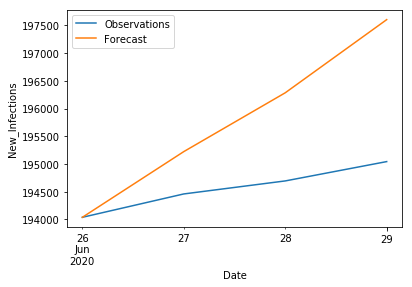

In [21]:
fig, ax = plt.subplots()
test_series.iloc[-4:].plot()
forecast_series.iloc[-4:].plot()
ax.set_ylabel('New_Infections')
ax.legend(['Observations', 'Forecast'])

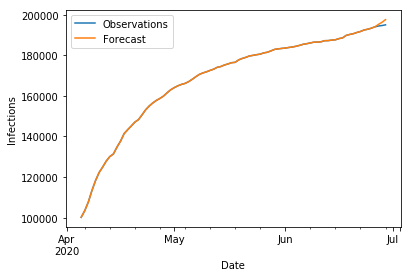

In [22]:
fig, ax = plt.subplots()
test_series.loc['2020-04-05':].plot()
forecast_series.loc['2020-04-05':].plot()
ax.set_ylabel('Infections')
ax.legend(['Observations', 'Forecast'])

# Model growth rate of Covid 19 in China 
## Fit polynom and extract parameters

In [24]:
#Get the Data 
CH = country_filter(data, Country='China')
state_list = CH['Province/State'].drop_duplicates()

### Example: Fit polynom to data in Zhejiang 

In [25]:
y = np.array(CH.loc[CH['Province/State']=='Zhejiang','Infected'].transform(lambda x: x*(100/x.max())))
x = np.array(range(0,len(y)),dtype=float)
#params,_ = fit(logistic,x,y)
params = np.polyfit(x,y, deg=3)
p = np.poly1d(params)
print(params)

[ 4.77277670e-04 -9.13708916e-02  5.43589768e+00 -1.57742360e-01]


Text(0,0.5,'Number of Infections in %')

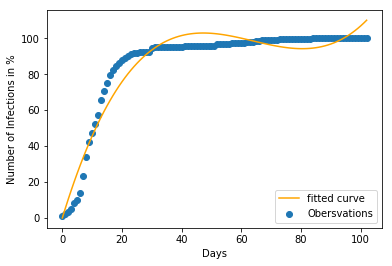

In [26]:
fig, axes = plt.subplots()
plt.scatter(x,y)
plt.plot(x,p(x),color='orange')
#plt.plot(x,logistic(x,params[0],params[1],params[2],params[3],params[4]),color='orange')
axes.legend(['fitted curve','Obersvations'])
axes.set_xlabel('Days')
axes.set_ylabel('Number of Infections in %')